The aim of this notebook is to perform basic exploratory data analysis (EDA), which in this competition include:

- deal with nan
- feature selection
- normality check
- convert strings to categorical values via LabelEncoder
- correlation matrix
- feature importance
- outlier deletion & normalization
- dimensionality reduction

I also show the basic of the so-called 'stacked-emsemble model' to boost our prediction accuracy!
- stacked-emsemble model using 'XGBoost', 'neural network, and 'support vector machine regression (SVR)' 
- submission

First, let's start with looking at what's inside of the given csv file.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# import data
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

train.head()

sample_submission.csv
test.csv
train.csv



,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


There seems to be several data types. 

In [2]:
print(train.dtypes)

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object
GarageYrBlt      float64


Yes, there are...but what is 'object'? Let's just have a look at one example 'SaleCondition'.

In [3]:
print(train['SaleCondition'].unique())

['Normal' 'Abnorml' 'Partial' 'AdjLand' 'Alloca' 'Family']


Essentially, 'object' is string. There needs to be a way to convert string to float or int. This is where **LabelEncoder** kicks in.

In [4]:
# string label to categorical values
from sklearn.preprocessing import LabelEncoder

for i in range(train.shape[1]):
    if train.iloc[:,i].dtypes == object:
        lbl = LabelEncoder()
        lbl.fit(list(train.iloc[:,i].values) + list(test.iloc[:,i].values))
        train.iloc[:,i] = lbl.transform(list(train.iloc[:,i].values))
        test.iloc[:,i] = lbl.transform(list(test.iloc[:,i].values))

print(train['SaleCondition'].unique())

[4 0 5 1 2 3]


In this way we can convert strings to categorical values.

Now let's see whether there are nan in the data. 

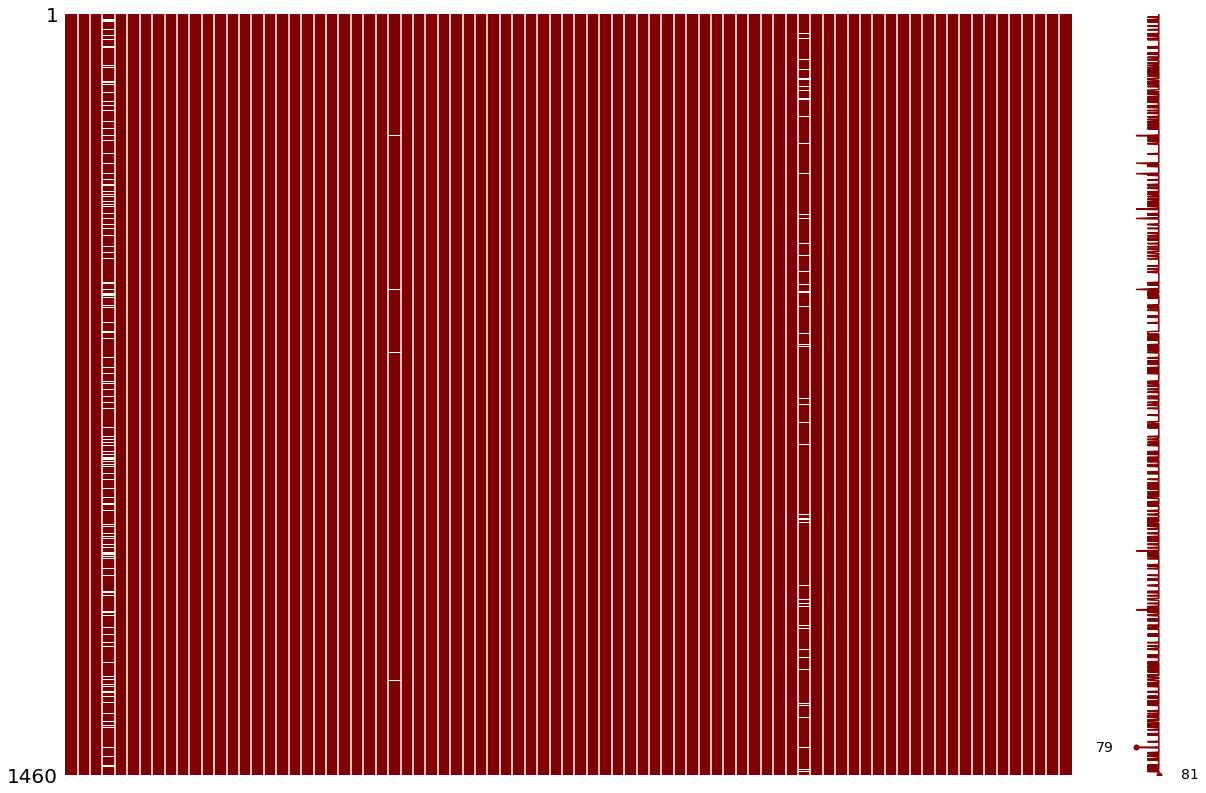

In [5]:
# search for missing data
import missingno as msno
msno.matrix(df=train, figsize=(20,14), color=(0.5,0,0))

The white elements have nan there. There seems to be some columns containing nan. 

In [6]:
# Which columns have nan?
print('training data+++++++++++++++++++++')
for i in np.arange(train.shape[1]):
    n = train.iloc[:,i].isnull().sum() 
    if n > 0:
        print(list(train.columns.values)[i] + ': ' + str(n) + ' nans')

print('testing data++++++++++++++++++++++ ')
for i in np.arange(test.shape[1]):
    n = test.iloc[:,i].isnull().sum() 
    if n > 0:
        print(list(test.columns.values)[i] + ': ' + str(n) + ' nans')


training data+++++++++++++++++++++
LotFrontage: 259 nans
MasVnrArea: 8 nans
GarageYrBlt: 81 nans
testing data++++++++++++++++++++++ 
LotFrontage: 227 nans
MasVnrArea: 15 nans
BsmtFinSF1: 1 nans
BsmtFinSF2: 1 nans
BsmtUnfSF: 1 nans
TotalBsmtSF: 1 nans
BsmtFullBath: 2 nans
BsmtHalfBath: 2 nans
GarageYrBlt: 78 nans
GarageCars: 1 nans
GarageArea: 1 nans


Actually, there are many columns in the test set to have nan. 'LotFrontage', 'MasVnrArea' and 'GarageYrBlt' have many nans in the both sets, so we just drop them. For others, there are a few nans in each column, so we just replace them with the median of the corresponding column.

Let's organize the data a bit better.

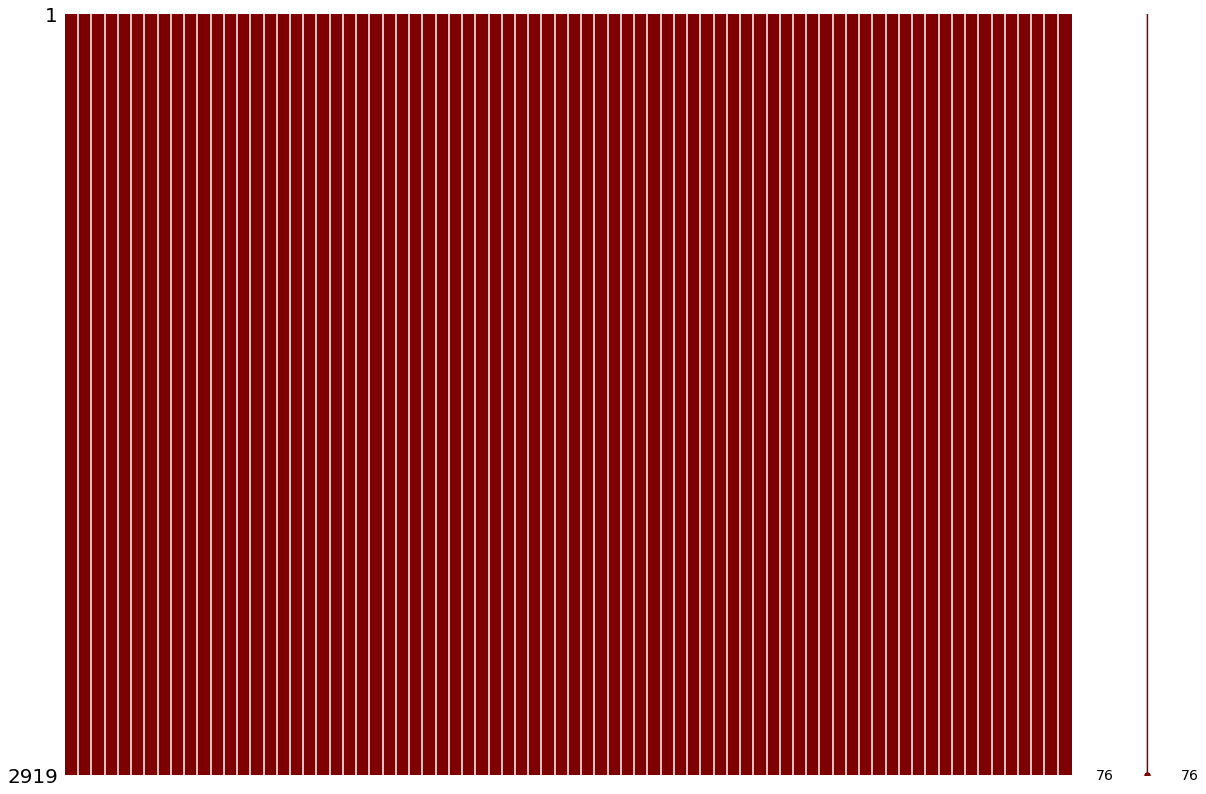

In [7]:
# keep ID for submission
train_ID = train['Id']
test_ID = test['Id']

# split data for training
y_train = train['SalePrice']
X_train = train.drop(['Id','SalePrice'], axis=1)
X_test = test.drop('Id', axis=1)

# dealing with missing data
Xmat = pd.concat([X_train, X_test])
Xmat = Xmat.drop(['LotFrontage','MasVnrArea','GarageYrBlt'], axis=1)
Xmat = Xmat.fillna(Xmat.median())

# check whether there are still nan
import missingno as msno
msno.matrix(df=Xmat, figsize=(20,14), color=(0.5,0,0))

OK, there are no nan any more! Let's check our columns again.

In [8]:
print(Xmat.columns.values)
print(str(Xmat.shape[1]) + ' columns')

['MSSubClass' 'MSZoning' 'LotArea' 'Street' 'Alley' 'LotShape'
 'LandContour' 'Utilities' 'LotConfig' 'LandSlope' 'Neighborhood'
 'Condition1' 'Condition2' 'BldgType' 'HouseStyle' 'OverallQual'
 'OverallCond' 'YearBuilt' 'YearRemodAdd' 'RoofStyle' 'RoofMatl'
 'Exterior1st' 'Exterior2nd' 'MasVnrType' 'ExterQual' 'ExterCond'
 'Foundation' 'BsmtQual' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1'
 'BsmtFinSF1' 'BsmtFinType2' 'BsmtFinSF2' 'BsmtUnfSF' 'TotalBsmtSF'
 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' '1stFlrSF' '2ndFlrSF'
 'LowQualFinSF' 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath' 'FullBath'
 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr' 'KitchenQual' 'TotRmsAbvGrd'
 'Functional' 'Fireplaces' 'FireplaceQu' 'GarageType' 'GarageFinish'
 'GarageCars' 'GarageArea' 'GarageQual' 'GarageCond' 'PavedDrive'
 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch' '3SsnPorch' 'ScreenPorch'
 'PoolArea' 'PoolQC' 'Fence' 'MiscFeature' 'MiscVal' 'MoSold' 'YrSold'
 'SaleType' 'SaleCondition']
76 columns


There are many '...SF'. Maybe we make a new feature which takes the sum of the all.

In [9]:
# add a new feature 'total sqfootage'
Xmat['TotalSF'] = Xmat['TotalBsmtSF'] + Xmat['1stFlrSF'] + Xmat['2ndFlrSF']
print('There are currently ' + str(Xmat.shape[1]) + ' columns.')

There are currently 77 columns.


Now let's have a look at the target distribution. As this is a regression task, we want the target to be normally distributed.

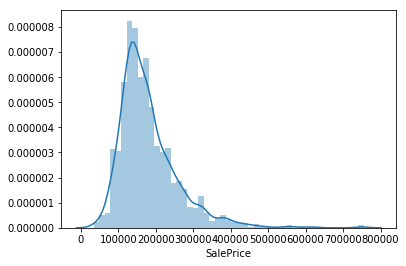

In [10]:
# normality check for the target
ax = sns.distplot(y_train)
plt.show()

Well, it is right-skewed. We use log-transform to make them normally distributed.

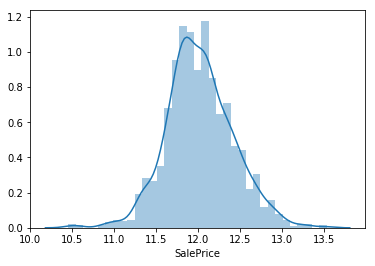

In [11]:
# log-transform the dependent variable for normality
y_train = np.log(y_train)

ax = sns.distplot(y_train)
plt.show()

This is (approximately) normal distribution! As a custom, let's have a look at correlation matrix.

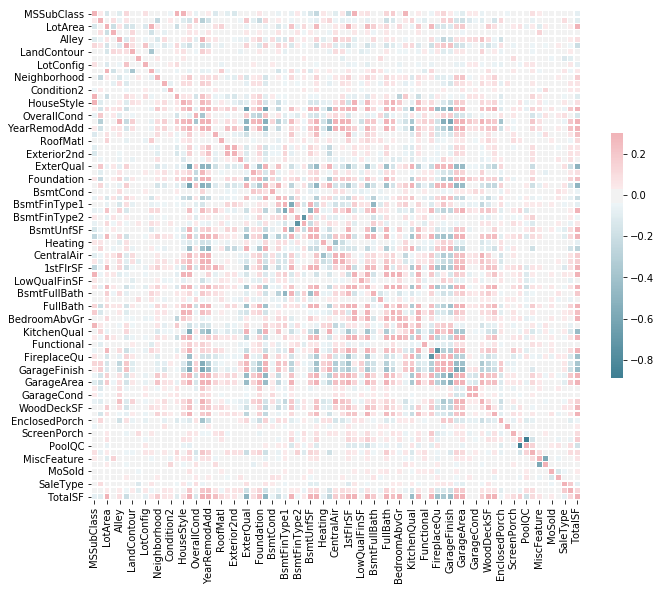

In [12]:
# train and test
X_train = Xmat.iloc[:train.shape[0],:]
X_test = Xmat.iloc[train.shape[0]:,:]

# Compute the correlation matrix
corr = X_train.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

Which features are important? Let a random forest regressor tell us about it.

Training done using Random Forest


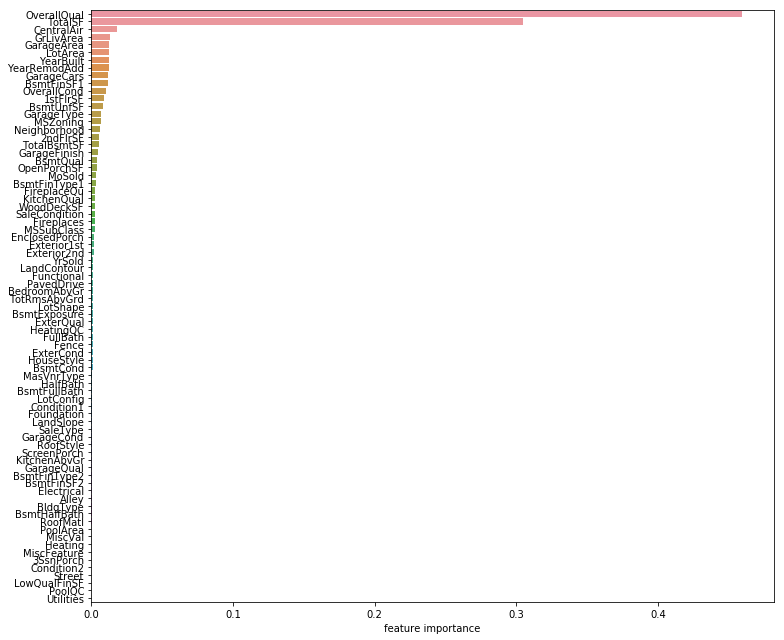

In [13]:
# feature importance using random forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=80, max_features='auto')
rf.fit(X_train, y_train)
print('Training done using Random Forest')

ranking = np.argsort(-rf.feature_importances_)
f, ax = plt.subplots(figsize=(11, 9))
sns.barplot(x=rf.feature_importances_[ranking], y=X_train.columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()
plt.show()

Surprisingly, only two features are dominant: 'OverallQual' and 'TotalSF'. So instead of using all the 77 features, maybe just using the top 30 features is good enough (dimensionality reduction, in a way).

Here, we make a new feature called 'Interaction': simply the multiplication between the top 2 features. Also, we normalize the data via z-scoring.

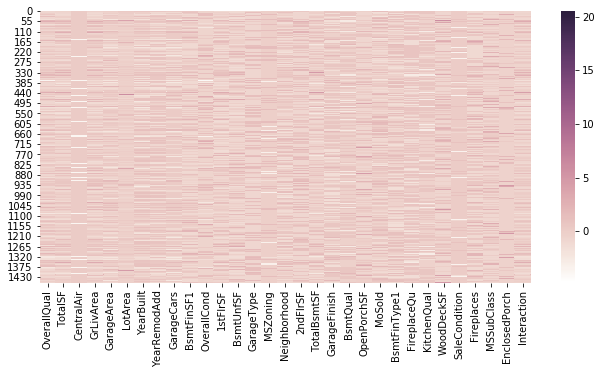

In [14]:
# use the top 30 features only
X_train = X_train.iloc[:,ranking[:30]]
X_test = X_test.iloc[:,ranking[:30]]

# interaction between the top 2
X_train["Interaction"] = X_train["TotalSF"]*X_train["OverallQual"]
X_test["Interaction"] = X_test["TotalSF"]*X_test["OverallQual"]

# zscoring
X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()
    
# heatmap
f, ax = plt.subplots(figsize=(11, 5))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(X_train, cmap=cmap)
plt.show()

Let' see how the important features are related to our target "SalePrice".

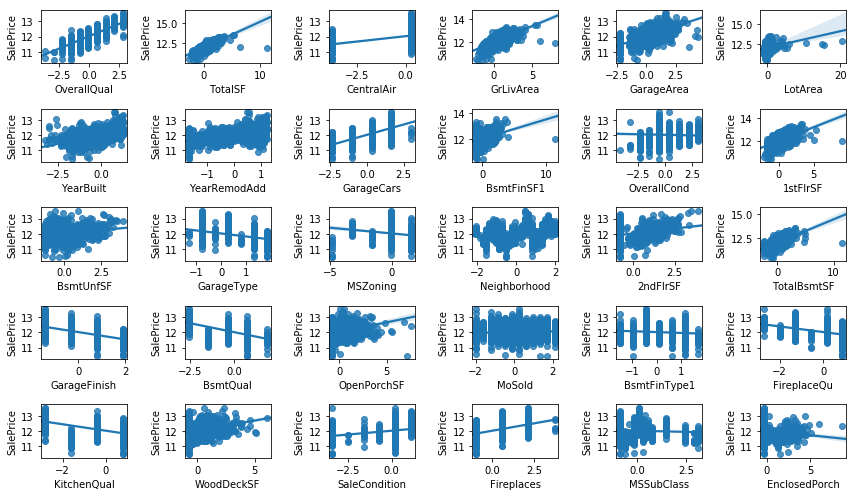

In [15]:
# relation to the target
fig = plt.figure(figsize=(12,7))
for i in np.arange(30):
    ax = fig.add_subplot(5,6,i+1)
    sns.regplot(x=X_train.iloc[:,i], y=y_train)

plt.tight_layout()
plt.show()

Basically we can see clear linear relationships in many panels. We do not see a lot of outliers, which is good. Maybe let's just remove some outlier data points found in the 'totalSF' and 'GrLivArea', which are apparently out of the linear regression line.

In [16]:
# outlier deletion
Xmat = X_train
Xmat['SalePrice'] = y_train
Xmat = Xmat.drop(Xmat[(Xmat['TotalSF']>5) & (Xmat['SalePrice']<12.5)].index)
Xmat = Xmat.drop(Xmat[(Xmat['GrLivArea']>5) & (Xmat['SalePrice']<13)].index)

# recover
y_train = Xmat['SalePrice']
X_train = Xmat.drop(['SalePrice'], axis=1)

Now it is time to have fun with the stacked-emsembling model! 

The intuitive idea of 'emsembling' is that we may be able to get better prediction performance if we average predictions by multiple models, rather than relying on a single model. There are always pros and cons in machine learning algorithms, so averaging multiple model predictions may compensate one another.

Here we use three models: XGBoost, Neural Network, and SVR.

Let's start with XGBoost. There are some parameters in XGBoost that can be optimized. We use 'GridSearch' to explore which combination of parameters yield the best prediction in this dataset.

In [17]:
# XGBoost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

print("Parameter optimization")
xgb_model = xgb.XGBRegressor()
reg_xgb = GridSearchCV(xgb_model,
                   {'max_depth': [2,4,6],
                    'n_estimators': [50,100,200]}, verbose=1)
reg_xgb.fit(X_train, y_train)
print(reg_xgb.best_score_)
print(reg_xgb.best_params_)

Parameter optimization
Fitting 3 folds for each of 9 candidates, totalling 27 fits
0.901762686158
{'max_depth': 2, 'n_estimators': 200}


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    4.2s finished


Moving on to neural network: we simply use Keras for easy implementation of multi-layer perceptron. 

We can again take advantage of grid search, but that requires Keras' wrapper 'KerasRegressor' (or 'KerasClassifier') to utilize scikit_learn's gird search. Here we try to select the best ones with respect to 'optimizer', 'batch_size', and 'epochs'. 

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

def create_model(optimizer='adam'):
    model = Sequential()
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

model = KerasRegressor(build_fn=create_model, verbose=0)
# define the grid search parameters
optimizer = ['SGD','Adam']
batch_size = [10, 30, 50]
epochs = [10, 50, 100]
param_grid = dict(optimizer=optimizer, batch_size=batch_size, epochs=epochs)
reg_dl = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
reg_dl.fit(X_train, y_train)

print(reg_dl.best_score_)
print(reg_dl.best_params_)

Using TensorFlow backend.
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


-0.0266391138249
{'batch_size': 10, 'epochs': 100, 'optimizer': 'SGD'}


Finally we implement our last regressor, which is SVR (support vector regressior). We can do that easily using sklearn. Again, we use grid search to optimize some of the SVR's hyperparameters.

In [19]:
# SVR
from sklearn.svm import SVR

reg_svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})
reg_svr.fit(X_train, y_train)

print(reg_svr.best_score_)
print(reg_svr.best_params_)

0.904752670556
{'C': 1.0, 'gamma': 0.01}


Alright, so far we have three models. Emsemble methods are simply averaging predicted results across models to improve overall accuracy. This method is based on the idea that prediction by each model may be independent of one another and thus averaging predictions across models may compensate one another and yield better solution.

Stacking methods are part of emsemble methods, but they use weighted averaging of predictions by models. The idea is, of course, you want to assign more weights on better models and less weights on worse ones, based on the dataset. To determine the weights, we treat predictions by models as new features (predictors) and train a linear model to predict our targets.

Here is the very nice documentation about the stacked-emsemble model.
'https://blogs.sas.com/content/subconsciousmusings/2017/05/18/stacked-ensemble-models-win-data-science-competitions/'

So let's first make a new matrix where each column represents prediction by each model.

In [20]:
# second feature matrix
X_train2 = pd.DataFrame( {'XGB': reg_xgb.predict(X_train),
     'NN': reg_dl.predict(X_train).ravel(),
     'SVR': reg_svr.predict(X_train),
    })
X_train2.head()

,NN,SVR,XGB
0,12.210778,12.211700,12.229466
1,12.242404,12.136536,12.124789
2,12.223771,12.268204,12.256313
3,11.795825,11.949866,11.932363
4,12.487927,12.542085,12.590397


We train a linear regressor for this new training matrix and predict our target! We use Lasso GLM to avoid overfitting. We predict our target 'SalePrice', but do not forget to convert it back to ordinal scale! It has been in log-scale for normality. 

In [21]:
# second-feature modeling using linear regression
from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(X_train2, y_train)

# prediction using the test set
X_test2 = pd.DataFrame( {'XGB': reg_xgb.predict(X_test),
     'DL': reg_dl.predict(X_test).ravel(),
     'SVR': reg_svr.predict(X_test),
    })

# Don't forget to convert the prediction back to non-log scale
y_pred = np.exp(reg.predict(X_test2))

Finally, we submit our prediction!

In [22]:
# submission
submission = pd.DataFrame({
    "Id": test_ID,
    "SalePrice": y_pred
})
submission.to_csv('houseprice.csv', index=False)

Note that, here we used a grid-search to optimize hyperparameters, but it is still not good enough because explored parameter spaces are still narrow. We could still optimize hyperparameters and go further up by:D 